# k-means clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import mode

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes

%config InlineBackend.figure_format = 'retina'

def gini(x):
    "See https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity"
    unique, counts = np.unique(x, return_counts=True)
    n = len(x)
    return 1 - np.sum( (counts / n)**2 )

## MNIST digits

In [2]:
# grab and uncompress from https://github.com/parrt/msds621/blob/master/data/mnist-train.csv.7z
df_digits = pd.read_csv("data/mnist-train.csv")
df_digits = df_digits.rename(columns={"label":"digit"})
df_digits.head(3)

,digit,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def imgrid(images,targets):
    fig, axes = plt.subplots(5, 5, figsize=(4, 4)) # make 5x5 grid of plots
    for i, ax in enumerate(axes.flat):
        img_as_row = images.iloc[i].values
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, targets[i], color='#313695', fontsize=18)

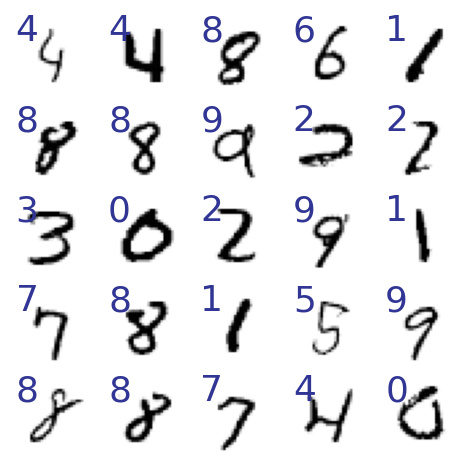

In [4]:
n = 25
df_subset = df_digits.sample(n=n, replace=False)
X = df_subset.drop('digit', axis=1) # get just pixels
y = df_subset['digit']

imgrid(X,targets=y.values)

In [5]:
def classify(df_digits, k = 100, verbose=True):
    X = df_digits.drop('digit', axis=1) # get just pixels
    y = df_digits['digit']
    kmeans = KMeans(k)
    kmeans.fit(X)
    y_cluster = kmeans.labels_ #kmeans.predict(X)

    labels = []
    modes = []
    accurs = []
    # For all instances in each kmeans cluster, cl, get collection of true digits from y
    # y_cluster==cl indicates which images are in cluster cl and y[y_cluster==cl] indicates
    # the true digit found at each image of that cluster. Then we use most common
    # true digit as guess for that cluster
    for cl in range(0,k):
        # convert from class to digit
        y_true_digits = y[y_cluster==cl].values
        most_common_digit = np.bincount(y_true_digits).argmax()
        accur = np.sum(y_true_digits==most_common_digit) / len(y_true_digits)
        modes.append(most_common_digit)
        accurs.append(accur)
        labels.append(most_common_digit)
        if verbose:
            print(y_true_digits[:30], f'mode = {most_common_digit}, gini = {gini(y_true_digits):.2f}, accur = {accur*100:.1f}%')
        
    return labels, modes, accurs

In [6]:
%%time
labels, modes, accurs = classify(df_digits, k=10)
print(f"Unique labels {np.unique(labels)}, within class avg accuracy {np.mean(accurs)*100:.1f}")

[5 8 8 8 9 3 8 8 8 6 5 5 8 8 5 8 5 0 8 8 5 8 0 5 8 8 5 9 8 8] mode = 8, gini = 0.64, accur = 53.0%
[2 2 2 2 2 2 5 2 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] mode = 2, gini = 0.18, accur = 90.2%
[3 3 3 3 2 5 2 2 3 3 3 5 3 3 8 0 8 3 5 5 5 8 3 3 3 5 8 3 0 3] mode = 3, gini = 0.64, accur = 53.0%
[4 0 7 9 4 4 4 7 7 9 5 4 4 9 6 4 2 7 9 4 7 4 4 7 7 3 9 4 9 4] mode = 4, gini = 0.72, accur = 35.6%
[0 0 0 0 0 0 5 0 0 0 0 0 0 6 0 0 2 0 5 0 0 5 0 0 0 0 0 0 5 0] mode = 0, gini = 0.38, accur = 77.9%
[7 9 7 9 9 9 4 7 4 9 4 7 4 9 9 9 9 7 7 9 7 4 4 7 9 7 9 4 7 7] mode = 7, gini = 0.69, accur = 43.1%
[6 6 2 6 6 6 6 6 6 6 6 6 6 4 6 6 1 6 6 6 6 2 6 6 6 0 6 6 6 6] mode = 6, gini = 0.26, accur = 85.7%
[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9] mode = 0, gini = 0.19, accur = 89.6%
[1 1 2 1 1 6 1 5 7 1 7 1 8 4 5 1 5 1 1 2 6 5 1 8 1 5 2 1 1 1] mode = 1, gini = 0.69, accur = 51.6%
[1 1 1 1 1 1 2 1 2 1 1 9 1 9 1 1 1 3 6 3 7 3 1 9 3 1 2 1 1 6] mode = 1, gini = 0.57, accur = 64.5%
Unique lab

We have just 10 digits but kmeans clustering will struggle to put all 7's into a single bucket for example, since many 1's will look the same. Let's increase number of clusters

In [7]:
%%time
labels, modes, accurs = classify(df_digits, k=20)
print(f"Unique labels {np.unique(labels)}, within class avg accuracy {np.mean(accurs)*100:.1f}")

[3 5 5 8 3 5 8 3 8 3 3 3 5 3 3 8 3 3 3 5 5 8 5 5 3 5 3 3 8 3] mode = 3, gini = 0.62, accur = 50.3%
[4 9 4 4 5 4 4 9 4 4 4 4 4 4 4 9 4 4 4 9 9 4 9 4 4 4 4 9 4 4] mode = 4, gini = 0.50, accur = 63.4%
[9 9 7 9 9 9 7 7 7 9 7 7 7 7 7 9 7 5 7 4 9 7 9 9 7 4 4 7 7 9] mode = 7, gini = 0.50, accur = 66.3%
[1 1 1 1 1 1 1 2 1 1 1 9 1 1 1 3 6 1 3 1 1 1 6 2 1 1 1 1 1 1] mode = 1, gini = 0.30, accur = 83.6%
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2] mode = 2, gini = 0.09, accur = 95.5%
[6 1 6 5 5 5 5 5 5 5 6 2 5 5 5 5 5 2 3 6 5 5 5 8 5 5 0 5 5 5] mode = 5, gini = 0.66, accur = 55.4%
[6 2 6 0 6 6 6 6 6 6 1 6 0 6 6 0 6 6 6 6 6 6 6 8 6 4 5 6 6 6] mode = 6, gini = 0.22, accur = 88.4%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0] mode = 0, gini = 0.10, accur = 95.0%
[1 1 1 1 1 1 8 1 1 1 2 6 5 1 1 1 1 1 1 7 1 1 1 1 1 1 1 1 1 1] mode = 1, gini = 0.30, accur = 83.3%
[3 3 3 3 8 5 3 5 8 8 8 8 8 8 8 3 8 8 8 3 3 3 3 5 8 8 2 3 3 5] mode = 8, gini = 0.67, accur = 45.4%
[5 3 3 3 9

In [8]:
%%time
labels, modes, accurs = classify(df_digits, k=100, verbose=False)
print(f"Unique labels {np.unique(labels)}, within class avg accuracy {np.mean(accurs)*100:.1f}")

Unique labels [0 1 2 3 4 5 6 7 8 9], within class avg accuracy 88.6
CPU times: user 4min 17s, sys: 1min 47s, total: 6min 5s
Wall time: 1min


In [9]:
%%time
labels, modes, accurs = classify(df_digits, k=200, verbose=False)
print(f"Unique labels {np.unique(labels)}, within class avg accuracy {np.mean(accurs)*100:.1f}")

Unique labels [0 1 2 3 4 5 6 7 8 9], within class avg accuracy 90.8
CPU times: user 8min 9s, sys: 3min 39s, total: 11min 48s
Wall time: 1min 51s


In [19]:
%%time
labels, modes, accurs = classify(df_digits, k=250, verbose=False)
print(f"Unique labels {np.unique(labels)}, within class avg accuracy {np.mean(accurs)*100:.1f}")

Unique labels [0 1 2 3 4 5 6 7 8 9], within class avg accuracy 91.4
CPU times: user 9min 23s, sys: 3min 50s, total: 13min 14s
Wall time: 2min 17s


## Breast cancer data

In [11]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [12]:
cancer = np.where(y==0)[0]
benign = np.where(y==1)[0]
len(cancer), len(benign)

(212, 357)

In [13]:
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X)
y_pred = kmeans.predict(X)

true_benign = np.unique(y_pred[benign], return_counts=True)[1]
true_cancer = np.unique(y_pred[cancer], return_counts=True)[1]
conf_matrix = np.concatenate([[true_benign],
                              [true_cancer]], axis=0)

pd.DataFrame(conf_matrix)

,0,1
0,356,1
1,82,130


In [14]:
gini(y_pred[benign]), gini(y_pred[cancer])

(0.0055865483448280795, 0.4743681025275899)

In [15]:
X.shape

(569, 30)

## Image color vector quantization

From [sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html)

Modified by parrt to load custom image.

In [16]:
%config InlineBackend.figure_formats = ['retina']

# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from skimage.io import imread
from time import time

def demo(n_colors = 10):
    parrt = imread("parrt.jpg")

    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    parrt = np.array(parrt, dtype=np.float64) / 255

    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(parrt.shape)
    assert d == 3
    image_array = np.reshape(parrt, (w * h, d))

    print("Fitting model on a small sub-sample of the data")
    t0 = time()
    image_array_sample = shuffle(image_array, random_state=0)[:2000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    print("done in %0.3fs." % (time() - t0))

    # Get labels for all points
    print("Predicting color indices on the full image (k-means)")
    t0 = time()
    labels = kmeans.predict(image_array)
    print("done in %0.3fs." % (time() - t0))


    codebook_random = shuffle(image_array, random_state=0)[:n_colors]
    print("Predicting color indices on the full image (random)")
    t0 = time()
    labels_random = pairwise_distances_argmin(codebook_random,
                                              image_array,
                                              axis=0)
    print("done in %0.3fs." % (time() - t0))


    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h, d))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image

    # Display all results, alongside original image
    fig, axes = plt.subplots(1,3,figsize=(10,10))
    axes[0].axis('off')
    axes[0].set_title(f'Original image\n(96,615 colors)', fontsize=14)
    axes[0].imshow(parrt)

    axes[1].axis('off')
    axes[1].set_title(f'Quantized image\n({n_colors} colors, k-Means)', fontsize=14)
    axes[1].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

    axes[2].axis('off')
    axes[2].set_title(f'Quantized image\n({n_colors} colors, at random)', fontsize=14)
    axes[2].imshow(recreate_image(codebook_random, labels_random, w, h))
    plt.tight_layout()
    plt.savefig("/Users/parrt/Desktop/parrt-quantized.jpg", bbox_inches=0)
    plt.show()

Automatically created module for IPython interactive environment


Fitting model on a small sub-sample of the data
done in 0.165s.
Predicting color indices on the full image (k-means)
done in 0.009s.
Predicting color indices on the full image (random)
done in 0.043s.


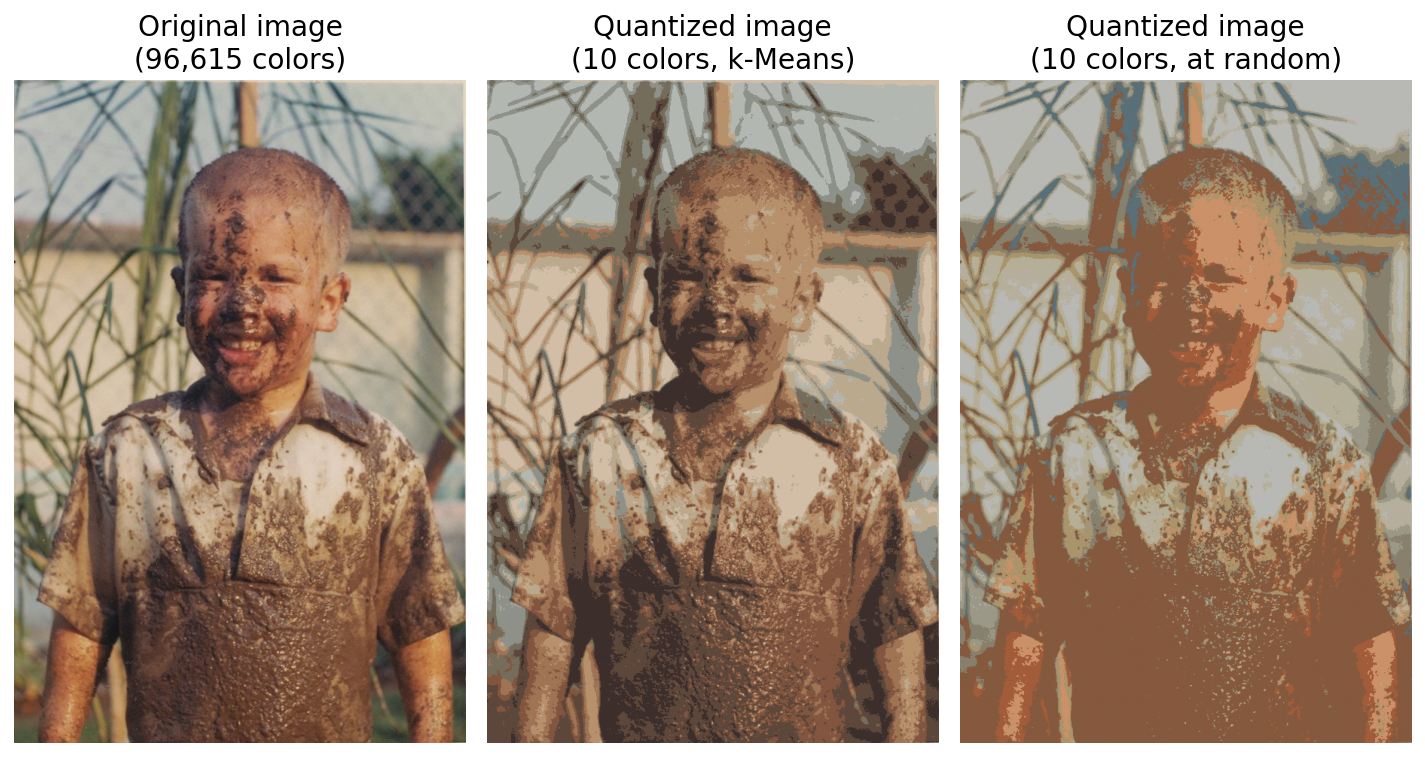

In [17]:
demo(n_colors=10)

Fitting model on a small sub-sample of the data
done in 0.121s.
Predicting color indices on the full image (k-means)
done in 0.007s.
Predicting color indices on the full image (random)
done in 0.024s.


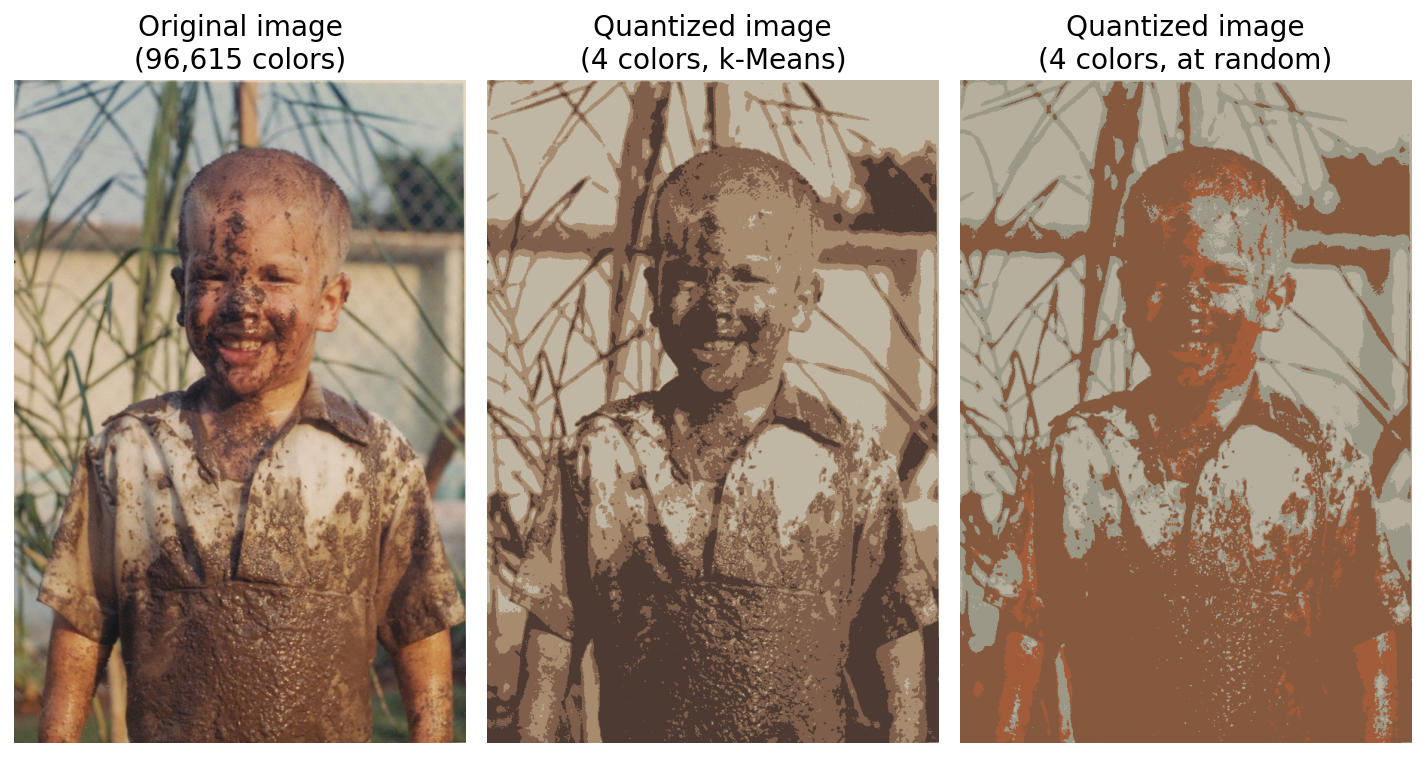

In [18]:
demo(n_colors=4)